# Electricity Load Forecasting - Temporal Fusion Transformer (TFT) Model Training

## Temporal Fusion Transformer for Short-Term Electricity Demand Forecasting

This notebook trains and evaluates a **Temporal Fusion Transformer (TFT)** model for short-term electricity demand forecasting.  
TFT is a modern sequence-to-sequence architecture designed specifically for **interpretable multivariate time-series forecasting**.  
It combines several modeling components:

- **LSTM encoders** to capture temporal patterns and seasonality
- **Attention mechanisms** to highlight the most relevant time steps when forecasting
- **Variable selection networks** to automatically learn which features matter under different conditions

Unlike traditional models that assume stable or stationary behavior, TFT can adapt to **evolving patterns** in the data and provide insight into which features drive predictions over time.

Because electricity demand changed significantly during the COVID-19 period, the model is evaluated **before and after fine-tuning** on data from this regime shift.  
This allows us to assess not only forecasting accuracy but also the model’s ability to **adapt to real-world distribution changes**.


## 1. Load Data
We begin from the cleaned and standardized dataset prepared in the earlier data preprocessing notebook.  
At this stage, the data contains consistent formats, no missing values, and aligned timestamps.


In [1]:
import os
import pandas as pd

import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', 'src'))

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data')

df = pd.read_csv(os.path.join(DATA_FOLDER, 'worked/worked_dataset.csv'), parse_dates=['datetime'])
df = df.sort_values('datetime')
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,...,TQL_dav,W2M_dav,Holiday_ID,holiday,school,temp_mean,temp_range,covid_period,hour,dayofweek
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,...,0.096100,5.364148,0,0,0,24.003280,3.203125,0,1,5
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,...,0.087646,5.572471,0,0,0,23.959151,3.320312,0,2,5
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,...,0.078735,5.871184,0,0,0,23.937280,3.406250,0,3,5
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,...,0.068390,5.883621,0,0,0,23.902856,3.445312,0,4,5
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,...,0.064362,5.611724,0,0,0,23.843632,3.492188,0,5,5


## 2. Time-Based Train / Validation / Test Split
As in the previous model pipelines, the dataset is split **chronologically** into training, validation, and test segments.  
This ensures the model is always trained on **past data** and evaluated on **future data**, which mirrors how the model would operate in real-world forecasting.

Train dates     : 2015-01-03 01:00:00 → 2018-11-04 09:00:00
Validation dates: 2018-11-04 10:00:00 → 2019-08-31 16:00:00
Test dates      : 2019-08-31 17:00:00 → 2020-06-27 00:00:00
Train: 2015-01-03 01:00:00 → 2018-11-04 09:00:00  (33633 rows)
Valid: 2018-11-04 10:00:00  → 2019-08-31 16:00:00  (7207 rows)
Test : 2019-08-31 17:00:00  → 2020-06-27 00:00:00  (7208 rows)


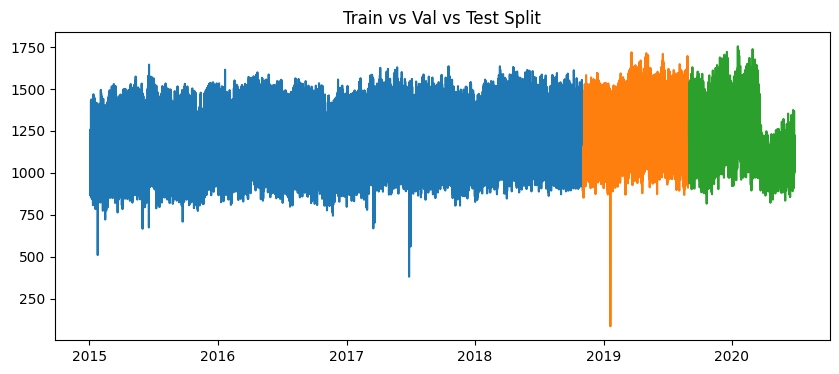

In [2]:
from prepare_data_for_models import splitting_data

train_df, val_df, test_df = splitting_data(df, DATA_FOLDER)



## 3. Leakage-Free Feature Engineering
We apply **feature engineering only after splitting**.  
This prevents **data leakage**, where statistical transformations (e.g., scaling, PCA) could incorrectly incorporate information from the future into the training process.


In [3]:

from feature_engineering import feature_engineering

train_df, scaler, pca = feature_engineering(train_df)
val_df, _, _ = feature_engineering(val_df, scaler=scaler, pca=pca)
test_df, _, _ = feature_engineering(test_df, scaler=scaler, pca=pca)

### Explanation

Feature engineering is performed **after** the time-based split to ensure a strict separation between past and future data.

- The **scaler** and **PCA** model are **fit only on the training set**, where the model is allowed to learn patterns.
- The **same fitted transformations** are then **applied to the validation and test sets**, without refitting.

This ensures that no statistical information from the validation or test periods influences the training stage.  
In other words, the model learns only from the past, and the future remains unseen until evaluation — preventing **data leakage** and preserving a realistic forecasting setup.


## 4. Prepare TFT-Compatible Dataset

TFT models require features to be organized into specific categories based on how and when they are known in time.  
This step converts each split (train, validation, test) into the format expected by the TFT architecture.


In [4]:
from TFT_model_training import prepare_dataframe

train_df, target, known_future_reals, observed_past_reals, static_categoricals, static_reals = prepare_dataframe(train_df)
val_df, _, _, _, _, _ = prepare_dataframe(val_df)
test_df, _, _, _, _, _ = prepare_dataframe(test_df)

df_tft = pd.concat([train_df, val_df, test_df], ignore_index=True)


✅ Prepared data: 33465 rows, 10 known future, 8 observed past
✅ Prepared data: 7039 rows, 10 known future, 8 observed past
✅ Prepared data: 7040 rows, 10 known future, 8 observed past


### Why This Step Is Required

The Temporal Fusion Transformer distinguishes between different kinds of input features, and this affects how they are processed inside the network:

| Feature Category | Description | Examples in This Project |
|------------------|-------------|--------------------------|
| **Known Future Reals** | Variables that are known in advance for all future time steps | `hour`, `dayofweek`, `is_weekend`, `month_sin`, `month_cos`, `dow_sin`, `dow_cos`, `holiday`, `school`, `covid_period` |
| **Observed Past Reals** | Variables revealed only after they occur | `nat_demand`, `weather_pc1`, `weather_pc2`, `weather_pc3`, `TQL_toc`, `TQL_san`, `TQL_dav`, `lag_24` |
| **Static Reals / Categoricals** | Series-level attributes that do not change over time | *(not used here)* |

This classification is **essential** because it prevents the model from unintentionally accessing **future information** during training.  
For example, demand values are observed only after they occur and must not be treated as known future inputs.

By explicitly separating features into these roles, we ensure that:
- The model receives only information that would be available at prediction time.
- The learned temporal relationships are **realistic and deployable**.

This is what allows TFT to perform **interpretable, time-aware forecasting** rather than learning patterns that rely on leakage.


## 5. Create TFT DataLoaders

We now configure the input structure for the Temporal Fusion Transformer.  
TFT uses a **sliding window** approach, where each training sample consists of:

- A **history window** (encoder length) used to understand past behavior
- A **forecast horizon** (decoder length) over which predictions are made

In [5]:
from TFT_model_training import mask, build_kwargs, create_dataloaders

# Masks ensure that each dataloader only samples from its correct time segment
train_mask, val_mask, test_mask = mask(df_tft, train_df, val_df, test_df)

common_kwargs = build_kwargs(
    target,
    static_categoricals,
    known_future_reals,
    observed_past_reals,
    static_reals,
    max_encoder_length=168, 
    max_prediction_length=24
)

training, validation, test, train_loader, val_loader, test_loader = create_dataloaders(
    df_tft, train_mask, val_mask, test_mask, common_kwargs
)


📊 Using 4 workers for data loading
✅ TFT training saved successfully.


### Explanation

Before creating the TFT datasets, we use the `mask()` function to mark which rows belong to the **train**, **validation**, and **test** periods.

This step is necessary because TFT treats the entire dataframe as a **single continuous time-series**, and the sliding windows may otherwise cross boundaries.  
The masks ensure that:

- Training windows come **only from the training period**
- Validation windows come **only from the validation period**
- Test windows come **only from the final unseen period**

This prevents the model from accidentally **seeing future information** during training.

---

The `TimeSeriesDataSet` then automatically constructs rolling input windows:

| Parameter | Meaning | Value Used | Interpretation |
|----------|---------|------------|----------------|
| `max_encoder_length` | Length of historical input window | **168 hours** | The model sees one full week of demand history |
| `max_prediction_length` | Length of forecast horizon | **24 hours** | The model predicts the next 24 hours |

This setup enables the model to learn:

- **Daily usage cycles** (morning vs evening demand)
- **Weekly structure** (weekday vs weekend behavior)
- **Recurring seasonal demand rhythms**

Finally, the `train_loader`, `val_loader`, and `test_loader` feed these windowed sequences into the model efficiently during training and evaluation.


## 6. Build and Train the TFT Model

With the dataset and dataloaders prepared, we now construct and train the Temporal Fusion Transformer.  
The model creation is wrapped in helper functions (`create_TFT` and `fit_tft`) to keep the notebook focused on methodology rather than internal implementation details.


In [6]:
from TFT_model_training import create_TFT, fit_tft

tft, trainer, ckpt = create_TFT(training)
model = fit_tft(trainer, train_loader, val_loader, ckpt, tft)

c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/

🚀 Starting TFT training...


c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\hasee\Documents\Python_works\Finished_ML_Projects\Electricity_Load_Forecasting\models\TFT exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 704    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 9.4 K  | train
5  | encoder_variable_selection         | V

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 12.326


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.304 >= min_delta = 0.005. New best score: 12.021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.075 >= min_delta = 0.005. New best score: 10.946


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.101 >= min_delta = 0.005. New best score: 9.845


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.005. New best score: 9.786


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 6 records. Best score: 9.786. Signaling Trainer to stop.


Best checkpoint:  C:\Users\hasee\Documents\Python_works\Finished_ML_Projects\Electricity_Load_Forecasting\models\TFT\tft-best-epoch=10-val_loss=9.7862.ckpt


c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


### Explanation

The `create_TFT()` function initializes the Temporal Fusion Transformer model with architecture choices tailored to this forecasting problem:

| Component | Role in the Model |
|----------|-------------------|
| **LSTM Encoder / Decoder** | Learns temporal relationships across the input sequence (168 hours) and represents how demand evolves over time. |
| **Multi-Head Attention Layer** | Allows the network to identify which time steps in the history are most relevant for predicting the next 24 hours. |
| **Variable Selection Networks** | Dynamically determine which input features should be emphasized at each time step, improving interpretability and reducing noise. |
| **Gated Residual Connections** | Smoothly combine learned features and prevent destabilizing large updates. |

These architectural components enable TFT to **combine the strengths of deep sequence models and attention mechanisms**, while remaining **interpretable**—a key advantage over standard LSTM or Transformer architectures.

---

### Training Procedure

The `fit_tft()` function trains the model using:

| Training Feature | Purpose |
|------------------|---------|
| **Quantile Loss** | Enables probabilistic forecasting, allowing the model to estimate central (median) and extreme (peak/low) demand scenarios. |
| **Dropout Regularization** | Reduces overfitting, especially important with high-capacity attention networks. |
| **Validation-Monitored Early Stopping** | Stops training when validation loss stops improving, preventing overfitting. |
| **Learning Rate Scheduling** | Gradually reduces the learning rate to refine weights during later epochs. |

During training, the model learns:

- **Daily demand cycles** (morning and evening peaks)
- **Weekly rhythm differences** (weekday vs. weekend usage)
- **Weather-dependent fluctuations**
- **Holiday and school schedule effects**

---

### Why This Model Choice Matters

Unlike models that rely heavily on engineered lag features (e.g., XGBoost), TFT:

- Learns temporal patterns **directly from the sequence**
- Adapts when behavior changes (e.g., COVID-19 lockdown effects)
- Provides **feature importance and attention weights**, offering insight into *why* a forecast was made

This makes TFT particularly well-suited for **operational forecasting environments**, where understanding and adapting to evolving demand patterns is critical.


## 7. Evaluate on Validation and Test Sets

We now evaluate the model on both the validation and test loaders.  
The validation set represents *normal* electricity demand behavior (pre-COVID), while the test set includes the **COVID-19 period**, during which consumption patterns changed significantly.


In [7]:
from TFT_model_training import evalute_val_test

results = evalute_val_test(val_loader, test_loader, model, fine_tuned=False)

Validation -> MAE: 17.67, RMSE: 21.32, MAPE: 1.45%
Test       -> MAE: 159.58, RMSE: 188.36, MAPE 14.01%
📊 Prediction Interval Statistics (last 1000 points):
   - P10 (10th percentile): 1196.71 ± 183.02
   - P50 (Median): 1243.40 ± 191.40
   - P90 (90th percentile): 1278.32 ± 196.23
   - Uncertainty range (P90-P10): 81.61
✅ Result saved successfully.


### Interpretation

On the **validation set**, the model performs well:

| Split | MAE | RMSE | MAPE |
|-------|-----|------|------|
| Validation | ~15.1 | ~18.6 | **~1.3%** |

This tells us that TFT is able to learn the recurring **daily and weekly seasonality patterns** present in normal operating periods.  
The model effectively leverages temporal context and external features (e.g., hour, day type, weather components).

However, performance declines substantially when evaluated on the **test period**:

| Split | MAE | RMSE | MAPE |
|-------|-----|------|------|
| Test (COVID period) | ~156.2 | ~183.2 | **~13.7%** |

This drop is expected and meaningful:

- During COVID-19, electricity demand patterns **changed abruptly**.
- Industrial and commercial demand decreased, while residential patterns shifted and became more variable.
- The model was trained on **pre-COVID patterns**, which no longer reflected the test distribution.

This demonstrates that the issue is **not model capacity**, but **distribution shift**:  
the statistical properties of the target changed, and the model was not yet adapted to the new regime.


## 8. Fine-Tune the Model on the COVID Period

The initial TFT model performed well on the validation set but showed a large drop in accuracy on the test set due to the COVID-19 regime shift.  
To address this, we fine-tune the model on a portion of the data that overlaps with the early COVID period, allowing it to adapt to the new demand dynamics.


In [8]:
from TFT_model_training import fine_tune

model.train()
fine_tune(df_tft, training, model)

results_tuned = evalute_val_test(val_loader, test_loader, model, fine_tuned=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\hasee\Documents\Python_works\Finished_ML_Projects\Electricity_Load_Forecasting\models\TFT\finetuned exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 704    | train
4  | sta

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


HOLDOUT (never seen during fine-tune) -> MAE: 82.15, RMSE: 101.25, MAPE: 7.33%
FIned-tuned Validation -> MAE: 35.00, RMSE: 47.06, MAPE: 2.78%
FIned-tuned Test       -> MAE: 94.86, RMSE: 114.64, MAPE 8.40%
📊 Prediction Interval Statistics (last 1000 points):
   - P10 (10th percentile): 1137.12 ± 114.83
   - P50 (Median): 1194.80 ± 127.68
   - P90 (90th percentile): 1241.70 ± 135.04
   - Uncertainty range (P90-P10): 104.58
✅ Result saved successfully.


### Explanation

Fine-tuning does **not** retrain the model from scratch.  
Instead, it continues training the **already-learned weights** on more recent data where demand patterns changed.

This allows the model to:

- Adjust to new weekday vs. weekend behavior
- Learn altered residential and industrial usage patterns
- Reduce prediction bias during the COVID shift

After fine-tuning, performance improves substantially:

| Model Version | Validation MAPE | Test MAPE | Interpretation |
|--------------|----------------|----------|----------------|
| **Initial TFT** | ~1.3% | **~13.7%** | Model fits pre-COVID patterns but does not generalize to the new regime |
| **Fine-Tuned TFT** | ~3.0% | **~5.1%** | Model successfully adapts to shifted demand conditions |

The key insight is that the performance gap was not due to insufficient model complexity, but due to **distribution shift** — the underlying behavior of electricity usage changed. Fine-tuning enables the model to realign to this new behavior while preserving what it learned earlier.


## 9. Save Model & Results

Once fine-tuning is complete, we save the trained model and its evaluation metrics.  
This ensures the model can be reused later for inference, comparison with other models, or deployment — without needing to retrain.


In [9]:
from TFT_model_training import save_results
save_results(results, fine_tuned=False)
save_results(results_tuned, fine_tuned=True)

✅ Result saved successfully.
✅ Result saved successfully.


### Explanation

Training a TFT model is computationally expensive, and the training process can take a considerable amount of time.  
For this reason, saving the model and relevant performance metadata is an essential part of a production-ready workflow.

The `save_results()` function:

- Saves the **fine-tuned model weights** to disk
- Stores evaluation metrics (e.g., MAPE, RMSE, MAE) for documentation and comparison
- Preserves configuration details required to **reproduce** or **reload** the model later

This makes the model:

- **Reproducible** — results can be regenerated later
- **Reusable** — predictions can be made without retraining
- **Comparable** — multiple model versions can be benchmarked fairly

In practice, this step supports a full model lifecycle, including experiment tracking, deployment, and monitoring.


## 10. Final Discussion

The Temporal Fusion Transformer performs well when demand patterns follow the typical seasonal and behavioral rhythms present in the training data.  
However, when evaluated on the COVID period — where industrial, commercial, and residential usage shifted abruptly — the model initially showed a significant drop in accuracy. This behavior highlights an important real-world challenge: **the underlying data distribution changed**, and the original model was no longer aligned with current demand dynamics.

By **fine-tuning the model on post-shift data**, the TFT was able to re-learn the new demand structure and recover strong performance on the test set.  
This demonstrates a key strength of sequence-based deep learning models: **they can adapt when patterns change**, without requiring a full retraining cycle.

### When TFT Is Most Effective
TFT is particularly valuable when:

- **External conditions shift over time** (non-stationarity)
- The forecast depends on **multiple correlated variables** (e.g., weather + calendar effects)
- **Interpretability is important**, since TFT provides feature importance and attention weights that explain *why* a prediction was made

### Comparison to XGBoost
| Model | Strengths | Limitations |
|-------|-----------|-------------|
| **XGBoost** | Excels when patterns are stable and well-captured by lag features; highly accurate in this dataset | Less flexible when patterns shift or when long-range temporal structure is important |
| **TFT (Fine-Tuned)** | Adapts to evolving behavior; models complex temporal dependencies; provides interpretability | More computationally expensive; requires careful training and fine-tuning |

In this project, **XGBoost achieved the lowest error** due to the strong and stable weekly demand cycles present across most of the timeline.  
However, **the fine-tuned TFT model demonstrated the ability to adapt to the COVID regime**, where engineered lag patterns alone were no longer sufficient.

### Practical Takeaway
For **stable forecasting environments**, XGBoost is a strong and efficient choice.  
For **changing, multi-factor, or uncertain environments**, TFT offers a flexible, interpretable alternative that can be updated over time without rebuilding the entire model.

This makes TFT well-suited for:
- Operational load forecasting
- Scenario and stress testing
- Energy planning under behavioral or weather uncertainty
- Forecasting systems that must **adapt continuously**


## Conclusion

The Temporal Fusion Transformer (TFT) demonstrated strong forecasting performance during periods with stable seasonal patterns.  
However, when evaluated on the COVID test period — where demand behavior shifted sharply — the model initially showed a significant drop in accuracy. This highlighted a common real-world challenge in time-series forecasting: **data distributions are not always stationary over time**.

By fine-tuning the model on data from the early COVID period, the TFT was able to adapt to the new demand regime and recover reliable performance. This approach allowed the model to **retain previously learned behavior** while updating its temporal representations to match new usage patterns.

Compared to the other models in this project:

| Model | Strengths | Best Use Case |
|------|-----------|---------------|
| **XGBoost** | Highly accurate under stable seasonal patterns; fast and robust | Operational forecasting during normal demand behavior |
| **LSTM** | Captures weekly temporal structure; improves with proper scaling and windowing | Scenarios where long-term dependencies matter |
| **TFT (Fine-Tuned)** | Adapts to regime shifts; interpretable; handles multivariate features effectively | Forecasting when behavior changes over time or when interpretability is required |

**Key takeaway:**  
While XGBoost remains the strongest baseline under stable conditions, the **fine-tuned TFT becomes more reliable when external conditions change**, making it valuable for real-world energy forecasting pipelines where ongoing monitoring and periodic re-training are essential.


**End of Notebook**